In [1]:
#1. Import the libraries:
import pandas as pd
#!pip install yfinance
import yfinance as yf
import statsmodels.formula.api as smf

In [3]:
import numpy as np

from matplotlib import pyplot as plt

from matplotlib import animation

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm 

import matplotlib.pyplot as plt

from sklearn import linear_model

In [ ]:
#import zipfile

In [ ]:
#2. Download the necessary data from prof. French's website:
#!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
# #!unzip -a F-F_Research_Data_Factors_CSV.zip
# with zipfile.ZipFile("F-F_Research_Data_Factors_CSV.zip", "r") as zip_ref:
#     zip_ref.extractall()
#!rm F-F_Research_Data_Factors_CSV.zip

In [4]:
#3. Define the parameters:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2013-12-31'
END_DATE = '2022-10-31'

In [8]:
#4. Load the data from the source CSV file and keep only the monthly data:
factor_df = pd.read_csv('DataTP2.csv',skiprows=3)
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

In [9]:
#5. Rename the columns of the DataFrame, set a datetime index, and filter by dates:
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']
factor_df['date'] = pd.to_datetime(factor_df['date'],format='%Y%m').dt.strftime("%Y-%m")
factor_df = factor_df.set_index('date')
factor_df = factor_df.loc[START_DATE:END_DATE]

In [10]:
#6. Convert the values into numeric values and divide by 100:
factor_df = factor_df.apply(pd.to_numeric,errors='coerce').div(100)


In [11]:
#7. Download the prices of the risky asset:
asset_df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],start=START_DATE,end=END_DATE,adjusted=True,progress=False)

In [12]:
#8. Calculate the monthly returns on the risky asset:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.strftime('%Y-%m')
y.name = ['rtn','market']

ff_data = factor_df.join(y)

<ipython-input-12-519823f43cc5>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  y.name = ['rtn','market']


In [13]:
#9. Merge the datasets and calculate the excess returns:

ff_data = factor_df.join(y)

ff_data['excess_rtn'] = ff_data.AMZN - ff_data.rf

In [14]:
X = ff_data['mkt'].values.reshape(-1,1)

y = ff_data['excess_rtn'].values

In [15]:
ols = linear_model.LinearRegression()

model = ols.fit(X, y)

response = model.predict(X)

R2 = model.score(X, y)

In [16]:
R2

0.3855711566476995

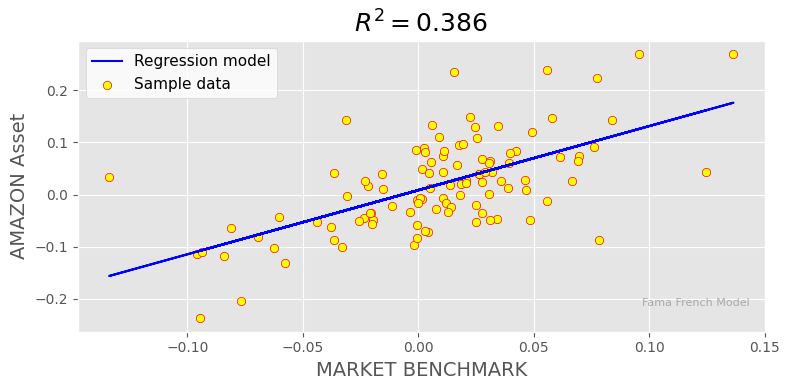

In [17]:
##############################################10- Plot ################################################


plt.style.use('default')

plt.style.use('ggplot')


fig, ax = plt.subplots(figsize=(8, 4))


ax.plot(X, response, color='b', label='Regression model')

ax.scatter(X, y, edgecolor='r', facecolor='yellow', alpha=0.99, label='Sample data')

ax.set_ylabel('AMAZON Asset', fontsize=14)

ax.set_xlabel('MARKET BENCHMARK', fontsize=14)

ax.text(0.9, 0.1, 'Fama French Model', fontsize=8, ha='center', va='center',

transform=ax.transAxes, color='grey', alpha=0.6)

ax.legend(facecolor='white', fontsize=11)

ax.set_title('$R^2= %.3f$' %R2, fontsize=18)


fig.tight_layout()

In [18]:
ff_model = smf.ols(formula='excess_rtn ~ mkt',

data=ff_data).fit()

print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     65.26
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.24e-12
Time:                        20:10:14   Log-Likelihood:                 131.19
No. Observations:                 106   AIC:                            -258.4
Df Residuals:                     104   BIC:                            -253.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0083      0.007      1.185      0.2

In [19]:
ff_data

,mkt,smb,hml,rf,AMZN,^GSPC,excess_rtn
date,,,,,,,
2014-01,-0.0332,0.0090,-0.0207,0.0000,-0.100554,-0.035583,-0.100554
2014-02,0.0465,0.0037,-0.0031,0.0000,0.009507,0.043117,0.009507
2014-03,0.0043,-0.0185,0.0493,0.0000,-0.071058,0.006932,-0.071058
2014-04,-0.0019,-0.0420,0.0117,0.0000,-0.095847,0.006201,-0.095847
2014-05,0.0206,-0.0188,-0.0013,0.0000,0.027685,0.021030,0.027685
...,...,...,...,...,...,...,...
2022-06,-0.0843,0.0209,-0.0597,0.0006,-0.116459,-0.083920,-0.117059
2022-07,0.0957,0.0281,-0.0410,0.0008,0.270596,0.091116,0.269796
2022-08,-0.0377,0.0139,0.0031,0.0019,-0.060615,-0.042440,-0.062515


In [20]:
X = ff_data[['mkt','hml']].values.reshape(-1,2)

Y = ff_data['excess_rtn'].values

In [21]:
x = X[:,0]
y = X[:,1]
z = Y

x_pred = np.linspace(-0.2,0.2,20)
y_pred = np.linspace(-0.2,0.2,20)

In [22]:
xx_pred, yy_pred = np.meshgrid(x_pred,y_pred)
model_viz = np.array([xx_pred.flatten(),yy_pred.flatten()]).T

In [23]:
ols = linear_model.LinearRegression()

model = ols.fit(X, Y)

predicted = model.predict(model_viz)

In [24]:
R2 = model.score(X, Y)
R2

0.5401458649470803

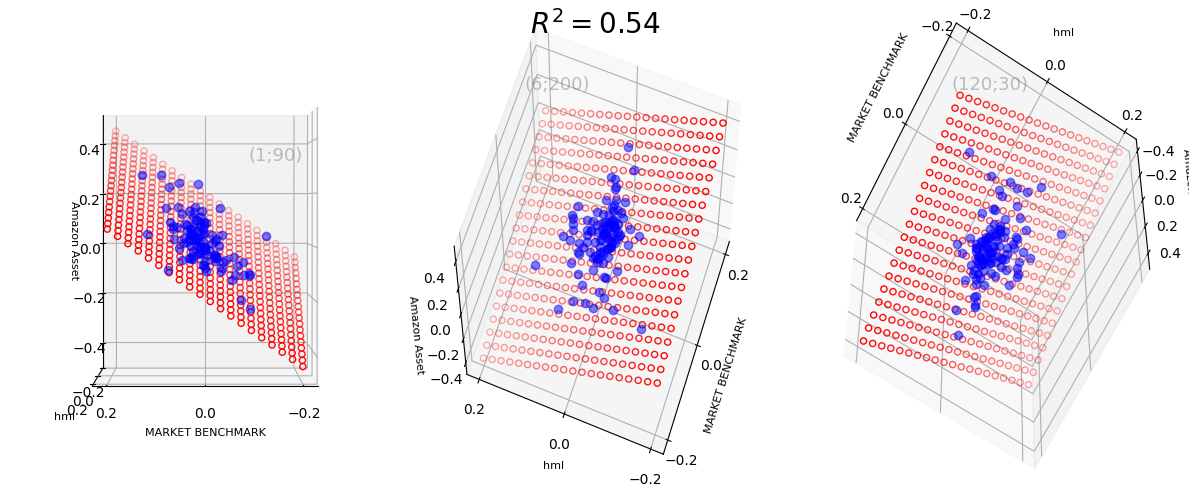

In [25]:
plt.style.use('default')
fig = plt.figure(figsize=(12,5))


ax1 = fig.add_subplot(131,projection="3d")
ax2 = fig.add_subplot(132,projection="3d")
ax3 = fig.add_subplot(133,projection="3d")

axes = [ax1,ax2,ax3]

for ax in axes:
    ax.plot(x,y,z,color='b',zorder = 20,linestyle='none',marker='o',alpha = 0.5)
    ax.scatter(xx_pred.flatten(),yy_pred.flatten(),predicted,facecolor=(0,0,0,0),s=20,edgecolor='red')
    ax.set_xlabel('MARKET BENCHMARK', fontsize=8)
    ax.set_ylabel('hml', fontsize=8)
    ax.set_zlabel('Amazon Asset', fontsize=8)
    ax.locator_params(nbins=4,axis='x')
    ax.locator_params(nbins=4,axis='y')
    
ax1.text2D(0.7,0.7,'(1;90)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax1.transAxes,color='grey')
ax2.text2D(0.4,0.85,'(6;200)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax2.transAxes,color='grey')
ax3.text2D(0.5,0.85,'(120;30)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax3.transAxes,color='grey')


ax1.view_init(elev = 1, azim = 90)
ax2.view_init(elev = 60, azim = 200)
ax3.view_init(elev = 120, azim = 30)

fig.suptitle('$R^2 = %.2f$' % R2,fontsize = 20)
fig.tight_layout()

In [30]:
import matplotlib.animation as animation
def animate_elv(i):
  ax1.view_init(elev=i , azim=30)
  ax2.view_init(elev=i , azim=90)
  ax3.view_init(elev=i , azim=150)
  return fig,
anim = animation.FuncAnimation(fig, animate_elv, frames=360,
                              interval=20, blit=True)
anim.save('elevation_animation3d.mp4', writer = 'ffmpeg', fps = 30)

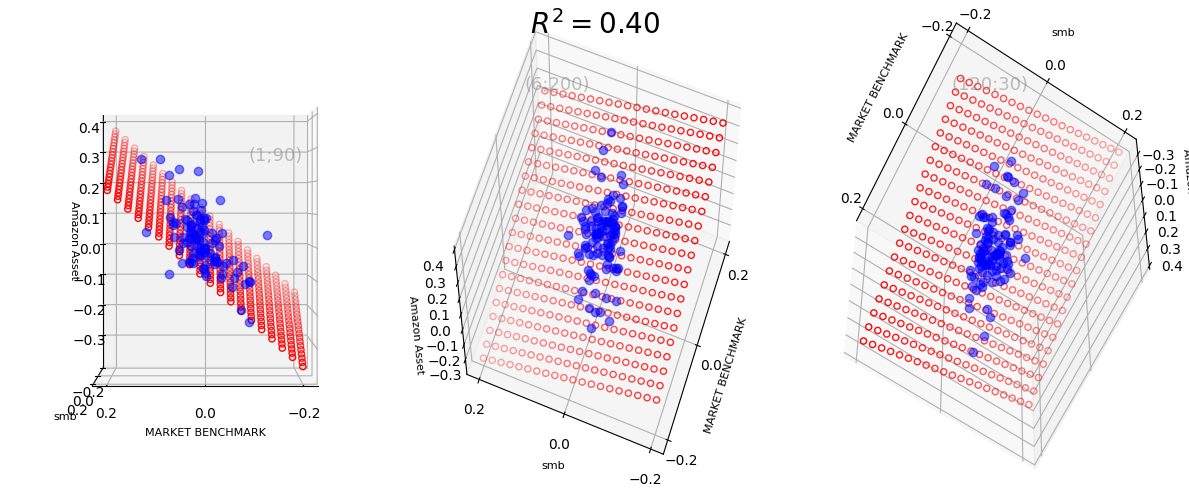

In [31]:
X = ff_data[['mkt','smb']].values.reshape(-1,2)

Y = ff_data['excess_rtn'].values

x = X[:,0]
y = X[:,1]
z = Y

x_pred = np.linspace(-0.2,0.2,20)
y_pred = np.linspace(-0.2,0.2,20)
xx_pred, yy_pred = np.meshgrid(x_pred,y_pred)
model_viz = np.array([xx_pred.flatten(),yy_pred.flatten()]).T

ols = linear_model.LinearRegression()

model = ols.fit(X, Y)

predicted = model.predict(model_viz)
R2 = model.score(X, Y)

plt.style.use('default')
fig = plt.figure(figsize=(12,5))


ax1 = fig.add_subplot(131,projection="3d")
ax2 = fig.add_subplot(132,projection="3d")
ax3 = fig.add_subplot(133,projection="3d")

axes = [ax1,ax2,ax3]

for ax in axes:
    ax.plot(x,y,z,color='b',zorder = 20,linestyle='none',marker='o',alpha = 0.5)
    ax.scatter(xx_pred.flatten(),yy_pred.flatten(),predicted,facecolor=(0,0,0,0),s=20,edgecolor='red')
    ax.set_xlabel('MARKET BENCHMARK', fontsize=8)
    ax.set_ylabel('smb', fontsize=8)
    ax.set_zlabel('Amazon Asset', fontsize=8)
    ax.locator_params(nbins=4,axis='x')
    ax.locator_params(nbins=4,axis='y')
    
ax1.text2D(0.7,0.7,'(1;90)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax1.transAxes,color='grey')
ax2.text2D(0.4,0.85,'(6;200)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax2.transAxes,color='grey')
ax3.text2D(0.5,0.85,'(120;30)',fontsize=13,ha='center',alpha=0.5,va='center',transform=ax3.transAxes,color='grey')


ax1.view_init(elev = 1, azim = 90)
ax2.view_init(elev = 60, azim = 200)
ax3.view_init(elev = 120, azim = 30)

fig.suptitle('$R^2 = %.2f$' % R2,fontsize = 20)
fig.tight_layout()

In [32]:
anim = animation.FuncAnimation(fig, animate_elv, frames=360,
                              interval=20, blit=True)
anim.save('2eme_elevation_animation3d.mp4', writer = 'ffmpeg', fps = 30)

In [33]:
X = ff_data[['mkt','smb','hml']].values.reshape(-1,3)

Y = ff_data['excess_rtn'].values

x = X[:,0]
y = X[:,1]
z = X[:,2]
w = Y

x_pred = np.linspace(-0.2,0.2,20)
y_pred = np.linspace(-0.2,0.2,20)
z_pred = np.linspace(-0.2,0.2,20)
xx_pred, yy_pred, zz_pred = np.meshgrid(x_pred,y_pred,z_pred)
model_viz = np.array([xx_pred.flatten(),yy_pred.flatten(),zz_pred.flatten()]).T

ols = linear_model.LinearRegression()

model = ols.fit(X, Y)

predicted = model.predict(model_viz)
R2 = model.score(X, Y)
R2

0.5574544810692568